# Utilizing Deepchem Molecular Models for **Crystalization Tendency** Regression of Polymers



## Table of Contents:
1. [Introduction](#introduction)
2. [Installation and Imports](#install)
3. [Data Loading](#dataload)
4. [Featurization, Model Training and Evaluation](#modeleval)
5. [Summary](#sum)
6. [Reference](#ref)

## 1. Introduction <a id="introduction"></a>

Polymer films are crucial in the production of certain pharmaceuticals, such as coated and modified-release dosage forms. These orally administered forms aim to control the release of the therapeutic agent, thereby regulating drug absorption from the gastrointestinal tract. A similar application is achieved using mucoadhesive films, where the solid active pharmaceutical ingredient (API) incorporated in the film layer is absorbed.`[2]`

During the preparation of a coating layer film, it is essential to understand its physicochemical properties, such as glass transition temperature, minimum film-forming temperature, flexibility, and surface properties. It is also important to know how the API particles are situated within the film-forming polymer structure and whether these particles alter the properties of the resulting film. Insoluble particles in the coating liquid can affect the final film's characteristics. APIs in the film layer are mostly in solid form and rarely dissolved; therefore, the particle size of the API is crucial, and the use of microcrystalline forms is recommended. The physicochemical properties are significantly influenced by the crystallization tendency of the polymer material. The crystalline form of the polymer film is critical for the controlled release of microcrystalline API particles. (As shown in Figure - 1)`[3,4]`



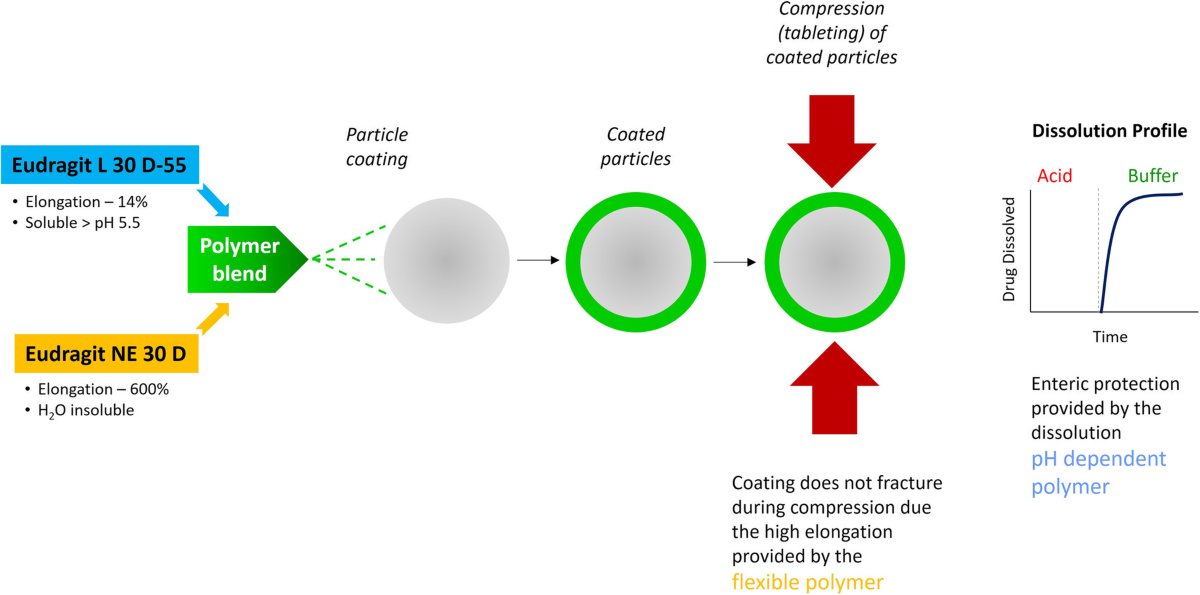

**Figure - 1**: The mechanism of coating polymer particles to form a flexible polymer layer to obtain control over release of drug over time. [[7]](#img-ref)

In this notebook, we will explore how to predict the crystallization tendency of polymers using DeepChem's molecular model architecture. We will employ standard featurizations and test various models to achieve optimal crystallization tendency predictions with minimal loss. Crystallization tendency is influenced by factors such as storage temperature, cooling conditions, and the internal crystal structure of the polymer. For this application, we will use SMILES strings representing base monomer molecules to perform regression analysis on the crystallization tendency of the polymers. `[5]`

Beyond this specific application, determining the crystallization tendency is broadly useful. A high degree of crystallinity is associated with excellent mechanical properties, essential for high-performance applications like composites. Conversely, low crystallinity enhances ion and gas mobility, which is crucial for battery and membrane applications.`[1]`

## 2. Installation and Imports <a id="install" />

In [ ]:
# Installation for deepchem (compatible for google colab with CUDA 12.1) [Must use with a GPU Instance]
%%capture --no-stderr
! pip install rdkit deepchem torch_geometric dgllife
! pip install -f https://download.pytorch.org/whl/cu118/torch_stable.html torch==2.2.1+cu118
! pip install  dgl -f https://data.dgl.ai/wheels/torch-2.2/cu121/repo.html

In [10]:
# All Imports
import pandas as pd
import deepchem as dc
from deepchem.feat import MolGraphConvFeaturizer
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
from sklearn.model_selection import train_test_split
IPythonConsole.ipython_useSVG=True

## 3. Data Loading <div id="dataload" />

We have collected a dataset of polymer SMILES mapped with their crystallization tendency. The research paper from which we have collected the dataset has been provided in the reference section.`[6]` In the code below we are downloading the dataset directly from github repository using `wget`.

In [ ]:
! wget "https://media.githubusercontent.com/media/ChangwenXu98/TransPolymer/master/data/Xc.csv"

In [4]:
df = pd.read_csv("./Xc.csv")
print("Number of data points", df.shape[0])
df.head()

Number of data points 432


,smiles,value
0,*C*,47.80
1,*CC(*)C,44.47
2,*CC(*)CC,34.04
3,*CC(*)CCC,20.01
4,*CC(*)CC(C)C,21.64


In [11]:
# Splitting the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
print("Number of data points in train set", train_df.shape[0])
print("Number of data points in test set", test_df.shape[0])

train_df.to_csv("train_Xc.csv",index=False)
test_df.to_csv("test_Xc.csv",index=False)

Number of data points in train set 388
Number of data points in test set 44


By examining the SMILES strings in the dataframe, we notice the use of `*` to denote an open bond. For instance, the second data point contains the SMILES `*CC(*)C`, representing the monomer state of propylene, which could be written as `C(H2)=C(H)C(H3)` with closed bonds. The double bond, represented by `=`, is broken to create open bonds, indicated by `*`, near the first two carbon atoms. (We can graphically visualize the same as the output of the code snippet below)

In this manner, a total of 432 polymer molecules are represented as SMILES strings. The crystallization tendency parameter, which serves as the target regression feature, is provided in the `value` column as a float datatype.

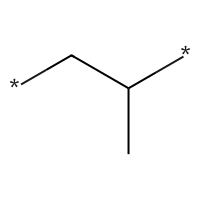

In [5]:
smiles = "*CC(*)C"
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(mol, kekulize=False, size=(200, 200))

## 4. Featurization, Model Training and Evaluation <a id="modeleval" />

With the required dataset loaded, we can proceed to train some models. Deepchem offers various models suitable for regression tasks in a molecular context. We have implemented a featurization mechanism, followed by model training, and recorded the training loss to validate the alignment of the data with the model.

For educational purposes and computational feasibility, we used a smaller dataset and implemented a lower number of epochs. However, for real-world applications, this process can be scaled with larger datasets and more computational resources to generate meaningful outcomes.

The process of training each model is going be of following steps.
###### i. Set the featurizer
###### ii. Featurize the input values and combine the target to form a dataset / dataloader
###### iii. Configure the model
###### iv. Fit the model with the dataset / dataloader and record the training loss.

### i. Graph Convolution Neural Network (GCN)

Graph Convolutional Neural Networks (GCNs) are particularly effective in molecular modeling, as they can directly operate on the graph structure of molecules. In the context of our study, GCNs can be employed to capture the intricate relationships between atoms and bonds, offering a powerful method for predicting the crystallization tendency of polymers. To understand more about GCNs and Graph Convolution, you can read out anther tutorial by clicking on this [link](https://deepchem.io/tutorials/introduction-to-graph-convolutions/).



In [30]:
# setting up the featurizer
molgraph_conv_featurizer = MolGraphConvFeaturizer()

# featurizing and preparing the dataset
X_molgraph_conv = molgraph_conv_featurizer.featurize(train_df["smiles"].values)
y_molgraph_conv = train_df["value"].values
molgraph_conv_dataset = dc.data.NumpyDataset(X_molgraph_conv, y_molgraph_conv)

X_molgraph_conv_test = molgraph_conv_featurizer.featurize(test_df["smiles"].values)
y_molgraph_conv_test = test_df["value"].values
molgraph_conv_dataset_test = dc.data.NumpyDataset(X_molgraph_conv_test, y_molgraph_conv_test)

metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
losses_gcn, val_losses_gcn = [], []
# initializing the model class
GCN_MODEL = dc.models.GCNModel(
    mode="regression",
    n_tasks=1,
    batch_size=2,
    learning_rate=0.001,
)

In [31]:
for n in range(20):
    l2_loss_GCN = GCN_MODEL.fit(molgraph_conv_dataset, nb_epoch=1)
    losses_gcn.append(l2_loss_GCN)
    val_loss_GCN = GCN_MODEL.evaluate(molgraph_conv_dataset_test, [metric])
    val_losses_gcn.append(val_loss_GCN)

### ii. Molecular Attention Transformer (MAT)

Molecular Attention Transformers provide a robust method for molecular modeling by leveraging the attention mechanism to analyze various parts of a molecule when making predictions. For this tutorial, these transformers can be useful for predicting the crystallization tendency of polymers. Unlike traditional models, Molecular Attention Transformers can dynamically assign weights to different atoms and bonds within the molecular structure, thereby capturing long-range dependencies and complex interactions more precisely. This approach enhances the model's capacity to discern intricate patterns in the molecular data, resulting in more accurate predictions. To learn more about the mechanism, you can go through this [tutorial](https://deepchem.io/tutorials/introduction-to-molecular-attention-transformer/).

In [ ]:
# setting up the featurizer
MAT_featurizer = dc.feat.MATFeaturizer()

# featurizing and preparing the dataset
MAT_data_loader = dc.data.CSVLoader(tasks=['value'], feature_field='smiles', featurizer=MAT_featurizer)
MAT_dataset = MAT_data_loader.create_dataset('./train_Xc.csv')
# featurizing the test data
MAT_dataset_test = MAT_data_loader.create_dataset('./test_Xc.csv')

# Evaluating the model
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
# setting up the loss storage
losses, val_losses = [], []

# initializing the model class
MAT_model = dc.models.torch_models.MATModel(batch_size=10)
for n_epoch in range(20):
    l2_loss_MAT = MAT_model.fit(MAT_dataset, nb_epoch=1)
    losses.append(l2_loss_MAT)
    val_losses.append(MAT_model.evaluate(MAT_dataset_test, [metric]))

### iii. Directed Message Passing Neural Network (D-MPNN)

Directed Message Passing Neural Networks (D-MPNNs) offer a sophisticated approach for molecular modeling by explicitly passing messages between atoms to capture the detailed structure of the molecule. In our study, D-MPNNs are used to predict the crystallization tendency of polymers. These networks operate by iteratively updating atom representations based on their neighbors, effectively capturing both local and global structural information. This method allows for precise modeling of the complex interactions within the molecular graph, leading to improved prediction accuracy. For better understanding of D-MPNN and it's integration with deepchem, [this tutorial](https://forum.deepchem.io/t/gsoc-22-d-mpnn-model-for-deepchem-report/803) can be helpful.

In [33]:
# setting up the featurizer
dmpnn_featurizer = dc.feat.DMPNNFeaturizer()

# featurizing and preparing the dataset
dmpnn_loader = dc.data.CSVLoader(tasks=['value'], feature_field='smiles', featurizer=dmpnn_featurizer)
dmpnn_dataset = dmpnn_loader.create_dataset('./train_Xc.csv')
dmpnn_dataset_test = dmpnn_loader.create_dataset('./test_Xc.csv')
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)

losses_dmpnn, val_losses_dmpnn = [], []

# initializing the model class
dmpnn_model = dc.models.torch_models.DMPNNModel(batch_size=10)

In [34]:
for n in range(20):
    dmpnn_loss = dmpnn_model.fit(dmpnn_dataset, nb_epoch=1)
    losses_dmpnn.append(dmpnn_loss)
    dmpnn_val_loss = dmpnn_model.evaluate(dmpnn_dataset_test, [metric])
    val_losses_dmpnn.append(dmpnn_val_loss)

#### Evaluation Analysis

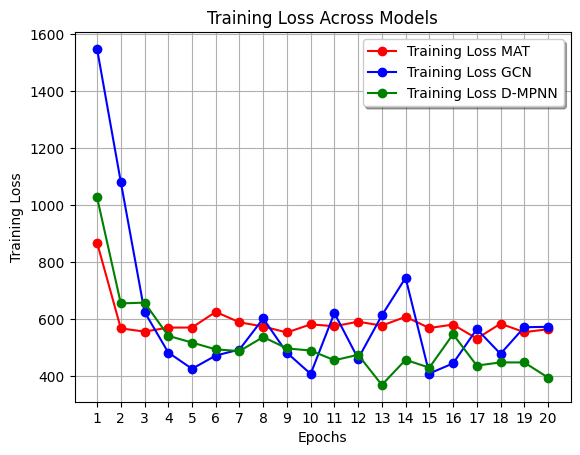

In [60]:

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

line1 = ax.plot(range(20), losses, label='Training Loss MAT', color='red', marker='o')
line2 = ax.plot(range(20), losses_gcn, label='Training Loss GCN', color='blue', marker='o')
line3 = ax.plot(range(20), losses_dmpnn, label='Training Loss D-MPNN', color='green', marker='o')

legend = ax.legend(loc='upper right', shadow=True)

custom_x_ticks = np.arange(0, 20, 1)
custom_x_label = [str(i+1) for i in custom_x_ticks]

ax.set_xticks(custom_x_ticks)
ax.set_xticklabels(custom_x_label)

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Across Models')
plt.grid(True)
plt.show()

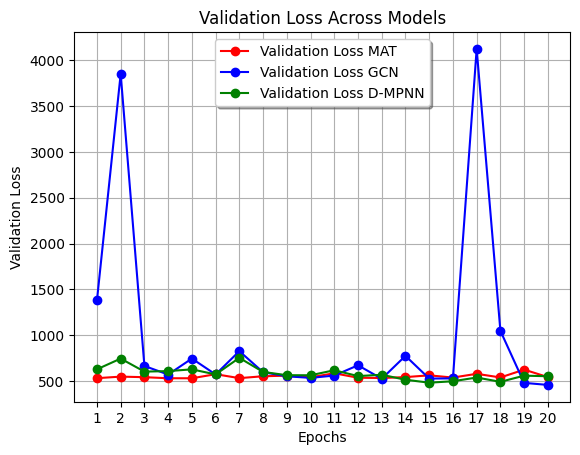

In [62]:
fig, ax = plt.subplots()

line1 = ax.plot(range(20), [x['mean_squared_error'] for x in val_losses], label='Validation Loss MAT', color='red', marker='o')
line2 = ax.plot(range(20), [x['mean_squared_error'] for x in val_losses_gcn], label='Validation Loss GCN', color='blue', marker='o')
line3 = ax.plot(range(20), [x['mean_squared_error'] for x in val_losses_dmpnn], label='Validation Loss D-MPNN', color='green', marker='o')

legend = ax.legend(loc='upper center', shadow=True)

custom_x_ticks = np.arange(0, 20, 1)
custom_x_label = [str(i+1) for i in custom_x_ticks]

ax.set_xticks(custom_x_ticks)
ax.set_xticklabels(custom_x_label)

plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Across Models')
plt.grid(True)
plt.show()

We employed three molecular models from DeepChem and recorded the training L2 loss for each epoch (Maximum of 20 epochs). Among the training L2 losses for GCN, MAT, and D-MPNN, the loss reduced to lowest for D-MPNN. Despite using the same input data and number of epochs, different architectures yielded slightly varying validation loss at end of 20 epochs. While the most reduction in validation is recorded for GCN model, D-MPNN showed a more stabilized reduction for validation loss.

## 5. Summary <a id="sum" ></a>
This notebook demonstrates how to predict the crystallization tendency of polymers using DeepChem's molecular model architecture.

**Key steps:**

1. **Data Loading:** A dataset of polymer SMILES strings mapped to their crystallization tendency is loaded.
2. **Featurization and Model Training:**
   - **Graph Convolutional Neural Network (GCN):** A GCN model is trained to capture the relationships between atoms and bonds in the polymer molecules.
   - **Molecular Attention Transformer (MAT):** A MAT model is employed to dynamically weigh different parts of the molecule for prediction.
   - **Directed Message Passing Neural Network (DMPNN):** A DMPNN model is used to learn representations of molecules by passing messages between atoms.
3. **Loss Evaluation:** The training loss of each model is recorded to assess their performance.
4. **Visualization:** A plot shows the training loss over epochs for the combined model.

**Conclusion:**

This tutorial provides a practical approach to predicting polymer crystallization tendency using DeepChem. By leveraging molecular modeling techniques, researchers and engineers can gain insights into the material properties of polymers, aiding in the design and development of new materials with desired characteristics.

## 6. References <a id='ref' ></a>

[1] [Venkatram, Shruti, et al. "Predicting crystallization tendency of polymers using multifidelity information fusion and machine learning." The Journal of Physical Chemistry B 124.28 (2020): 6046-6054.](https://pubs.acs.org/doi/10.1021/acs.jpcb.0c01865)

[2] [Rathi, Sneha, Rahul B. Chavan, and Nalini R. Shastri. "Classification of the crystallization tendency of active pharmaceutical ingredients (APIs) and nutraceuticals based on their nucleation and crystal growth behaviour in solution state." Drug Delivery and Translational Research 10.1 (2020): 70-82.](https://pubmed.ncbi.nlm.nih.gov/31407270/)

[3] [Rohani, Sohrab. "Applications of the crystallization process in the pharmaceutical industry." Frontiers of Chemical Engineering in China 4 (2010): 2-9.](https://www.researchgate.net/publication/226764666_Applications_of_the_crystallization_process_in_the_pharmaceutical_industry)

[4] [Bölcskei, É., et al. "Testing of the structure of macromolecular polymer films containing solid active pharmaceutical ingredient (API) particles." Radiation Physics and Chemistry 80.7 (2011): 799-802.](https://sciencedirect.com/science/article/abs/pii/S0969806X11000946)

[5] [Kawakami, Kohsaku. "Crystallization tendency of pharmaceutical glasses: relevance to compound properties, impact of formulation process, and implications for design of amorphous solid dispersions." Pharmaceutics 11.5 (2019): 202.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6572324/)

[6] [Kuenneth, C., et al. "Polymer informatics with multi-task learning. Patterns 2, 100238." (2021).](https://www.sciencedirect.com/science/article/pii/S2666389921000581)

[7] [Nyamweya, Nasser N. "Applications of polymer blends in drug delivery." Future Journal of Pharmaceutical Sciences 7 (2021): 1-15.](https://fjps.springeropen.com/articles/10.1186/s43094-020-00167-2)<a id="img-ref"></a>


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.

In [ ]:
@manual{Intro1,
 title={Utilizing Deepchem Molecular Models for Crystalization Tendency Regression of Polymers},
 organization={DeepChem},
 author={Mohanty, Debasish},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/crystallization_tendency_regression.ipynb}},
 year={2024},
}